In [ ]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 6)

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

<h3>Time series prediction method</h3>

In [ ]:
df = pd.read_csv('data/weather_2010-2016.csv');

In [ ]:
y = np.array(df['Temp'].dropna(axis=0, how='any'))

In [ ]:
from dateutil.parser import parse

df['Date'] = df['Date'].apply(lambda d: parse(d, dayfirst=True).date())

In [ ]:
df = df.groupby('Date', as_index=False, sort=True)['Temp'].mean()
y = np.array(df['Temp'])

In [ ]:
# data normalizarion for MLP
mean = np.mean(y)
range_y = np.max(y) - np.min(y)
y = (y - mean) / range_y

In [ ]:
train_size = int(len(y) * 0.6)
test_size = int((len(y) - train_size) / 2)
train, test = y[0:train_size], y[train_size:train_size + test_size]
X_train = np.arange(train_size)
X_test = np.arange(train_size, train_size + test_size)
X_holdout = np.arange(train_size + test_size, len(y))

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 5
trainX, trainY = create_dataset(train.reshape(-1, 1), look_back)
testX, testY = create_dataset(test.reshape(-1, 1), look_back)

In [ ]:
poly = PolynomialFeatures(2)
trainX = poly.fit_transform(trainX)
testX = poly.fit_transform(testX)

lin_reg = LinearRegression()
lin_reg.fit(trainX, trainY)
trainPredict = lin_reg.predict(trainX)
testPredict = lin_reg.predict(testX)

print("LinearRegression(train) mse =", mean_squared_error(trainY, trainPredict))
print("LinearRegression(test) mse =", mean_squared_error(testY, testPredict))

In [ ]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(1, 10)}

knn = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)
knn.fit(trainX, trainY)
trainPredict = knn.predict(trainX)
testPredict = knn.predict(testX)
print("kNN(train) mse =", mean_squared_error(trainY, trainPredict))
print("kNN(test) mse =", mean_squared_error(testY, testPredict))

In [ ]:
nn = MLPRegressor(alpha=0.1, hidden_layer_sizes=(1000, 1000))
nn.fit(trainX, trainY)
trainPredict = nn.predict(trainX)
testPredict = nn.predict(testX)

trainY = trainY * range_y + mean
trainPredict = trainPredict * range_y + mean
testY = testY * range_y + mean
testPredict = testPredict * range_y + mean

print("NN(train) mse =", mean_squared_error(trainY, trainPredict))
print("NN(test) mse =", mean_squared_error(testY, testPredict))

# nn_grid = GridSearchCV(nn, param_grid={
#     'alpha': 10.0 ** -np.arange(1, 7),
#     'hidden_layer_sizes': [(5, 5), (100, 100), (1000, 1000)]},
#     cv=5, n_jobs=4, verbose=True
# )
# nn_grid.fit(trainX, trainY)

In [ ]:
plt.plot(y);

y_train_pred = np.r_[y[0:look_back], trainPredict]
plt.plot(X_train, y_train_pred);
y_test_pred = np.r_[y[train_size: train_size + look_back], testPredict]
plt.plot(X_test, y_test_pred);

yy = y[train_size + test_size - look_back: train_size + test_size]

nextX = yy

for i in range(len(X_holdout)):
    pred = lin_reg.predict(poly.fit_transform(nextX.reshape(1, -1)))
    yy = np.append(yy, pred)
    nextX = np.append(nextX[1:len(nextX)], pred)
    
plt.plot(X_holdout, yy[look_back:len(yy)]);

<h3>Traditional method</h3>

In [139]:
df = pd.read_csv('data/weather_2010-2016.csv');

from dateutil.parser import parse
df['Date'] = df['Date'].apply(lambda d: parse(d, dayfirst=True).date())
df = df.groupby('Date', as_index=False, sort=True)['Temp'].mean()
df['month'] = df['Date'].apply(lambda d: d.month)
df['day'] = df['Date'].apply(lambda d: d.day)
df.drop('Date', axis=1, inplace=True)

In [140]:
y = df['Temp'].values
df.drop('Temp', axis=1, inplace=True)

In [141]:
# X_train, X_cv, y_train, y_cv = train_test_split(df.values, y, test_size=0.3, random_state=17)

train_size = int(len(y) * 0.6)
test_size = int(len(y) - train_size)
X_train, X_cv = df[0:train_size].values, df[train_size:len(y)].values
y_train, y_cv = y[0:train_size], y[train_size:len(y)]

In [ ]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(1, 50)}

knn = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)
knn.fit(X_train, y_train)
trainPredict = knn.predict(X_train)
testPredict = knn.predict(X_cv)
print("kNN(train) mse =", mean_squared_error(y_train, trainPredict))
print("kNN(test) mse =", mean_squared_error(y_cv, testPredict))

In [ ]:
tree = DecisionTreeRegressor(max_depth=8, min_samples_leaf=30)
tree.fit(X_train, y_train)
mean_squared_error(y_cv, tree.predict(X_cv))

In [134]:
poly = PolynomialFeatures(4)
X_train = poly.fit_transform(X_train)
X_cv = poly.fit_transform(X_cv)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
trainPredict = lin_reg.predict(X_train)
testPredict = lin_reg.predict(X_cv)

print("LinearRegression(train) mse =", mean_squared_error(y_train, trainPredict))
print("LinearRegression(test) mse =", mean_squared_error(y_cv, testPredict))

LinearRegression(train) mse = 20.4873751871
LinearRegression(test) mse = 20.7255769019


In [148]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_cv = scaler.transform(X_cv)

nn = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100))
# nn_grid = GridSearchCV(nn, param_grid={
# #     'alpha': 10.0 ** -np.arange(1, 7),
#     'hidden_layer_sizes': [(100, 100), (200, 200)]},
#     cv=5, n_jobs=4, verbose=True
# )
nn.fit(X_train, y_train)
# print(nn_grid.best_params_)
# print(nn_grid.cv_results_)
trainPredict = nn_grid.predict(X_train)
testPredict = nn_grid.predict(X_cv)

print("NN(train) mse =", mean_squared_error(y_train, trainPredict))
print("NN(test) mse =", mean_squared_error(y_cv, testPredict))

NN(train) mse = 22.4793821072
NN(test) mse = 20.3335079991


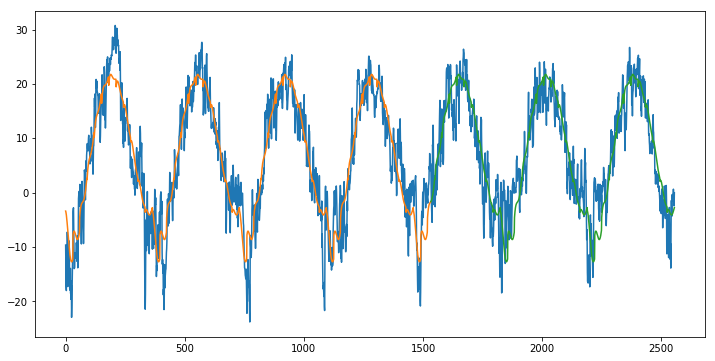

In [137]:
plt.plot(y);
plt.plot(np.arange(train_size), trainPredict)
plt.plot(np.arange(train_size, len(y)), testPredict)